In [283]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf 

from tqdm.notebook import tqdm
from keras import Sequential, Model
from keras.layers import Input, Dense

import matplotlib.pyplot as plt 
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification
from tokenizers import BertWordPieceTokenizer

from sklearn.model_selection import train_test_split
from keras.backend import clear_session
from tensorflow.keras import activations

In [284]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print('Tensorflow: ' + tf.__version__)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'not available')

BERT_PATH = "tokenizers/distilbert-base-cased"
MODEL_NAME = 'distilbert-base-cased'
MAX_LEN = 64
SEED = 42

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensorflow: 2.4.0
GPU is available


In [300]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')
df_submission = pd.read_csv('nlp-getting-started/sample_submission.csv')


In [302]:
# Download pretrained with vocab.txt file to location
tokenizer_base = DistilBertTokenizer.from_pretrained(MODEL_NAME)
tokenizer_base.save_pretrained(BERT_PATH)

# Load BertWordPiece with downloaded vocab.txt file
tokenizer = BertWordPieceTokenizer(
    f'{BERT_PATH}/vocab.txt', 
    lowercase=False
)

In [165]:
def create_encodings(batch_sentences, tknzr, max_len=64):
    return tknzr(batch_sentences, padding='max_length', truncation=True, max_length=max_len)

In [303]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=64):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size]
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [304]:
# Split training data in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train.text.tolist(), 
    df_train.target.values, 
    test_size=0.2, 
    stratify = df_train.target.values, 
    random_state=SEED)

X_test = df_test.text.tolist()

# Do encodings
# X_train_enc = create_encodings(X_train, tokenizer, max_len=MAX_LEN)
# X_valid_enc = create_encodings(X_valid, tokenizer, max_len=MAX_LEN)
# X_test_enc = create_encodings(X_test, tokenizer, max_len=MAX_LEN)
X_train_enc = fast_encode(X_train, tokenizer, maxlen=MAX_LEN)
X_valid_enc = fast_encode(X_valid, tokenizer, maxlen=MAX_LEN)
X_test_enc = fast_encode(X_test, tokenizer, maxlen=MAX_LEN)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [305]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train_enc, y_train))
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

valid_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_valid_enc, y_valid))
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (
    tf.data.Dataset
    .from_tensor_slices(X_test_enc)
    .batch(BATCH_SIZE)
)


In [228]:
model = Sequential(
    [
        Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids"),
        TFDistilBertModel.from_pretrained(MODEL_NAME),
        Dense(1, activation='sigmoid')
    ]
)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` c

In [306]:
def build_model():

    # model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
    
    inputs = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    outputs = TFDistilBertModel.from_pretrained(MODEL_NAME)(inputs)[0]
    cls_token = outputs[:, 0, :]
    out = Dense(1, activation='sigmoid', name='classifier')(cls_token)
    
    model = Model(inputs=inputs, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

    return model
    

In [307]:
model = build_model()
model.summary()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` c

In [207]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [308]:
# %%time

# n_steps = X_train_enc.shape[0]

history = model.fit(train_ds,
                    epochs=4,
                    validation_data=valid_ds,
                    verbose=2)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
Epoch 1/4
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to

In [309]:
history_valid = model.fit(
    valid_ds,
    epochs=6,
    verbose=2)


Epoch 1/6
48/48 - 10s - loss: 0.4039 - accuracy: 0.8372
Epoch 2/6
48/48 - 10s - loss: 0.3161 - accuracy: 0.8713
Epoch 3/6
48/48 - 10s - loss: 0.2365 - accuracy: 0.9087
Epoch 4/6
48/48 - 10s - loss: 0.1760 - accuracy: 0.9330
Epoch 5/6
48/48 - 10s - loss: 0.1119 - accuracy: 0.9547
Epoch 6/6
48/48 - 10s - loss: 0.0831 - accuracy: 0.9659


In [294]:
benchmarks = model.evaluate(test_ds, return_dict=True)
print(benchmarks)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
102/102 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
{'loss': 0.0, 'accuracy': 0.0}


In [252]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
    fig.subplots_adjust(hspace=0.5)
    
    ax1.plot(history['loss'], label='loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['accuracy'], label='Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

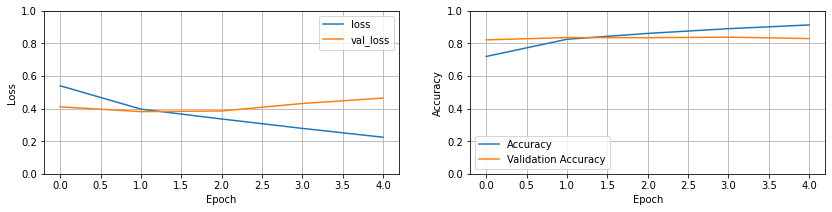

In [253]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist
plot_history(hist)

In [310]:
preds = model.predict(test_ds, verbose=1)
# preds = activations.softmax(tf.convert_to_tensor(preds[0])).numpy()

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
102/102 [==============================] - 8s 68ms/step


In [311]:
preds[:20]
# preds.shape

array([[9.9923182e-01],
       [9.9862146e-01],
       [9.9980193e-01],
       [9.9997544e-01],
       [9.9984181e-01],
       [9.8162019e-01],
       [1.3450540e-02],
       [6.4914150e-04],
       [9.8375534e-04],
       [1.1629907e-02],
       [1.0008061e-02],
       [1.9448489e-02],
       [4.9764439e-03],
       [4.1710325e-03],
       [1.5414918e-02],
       [9.7187144e-01],
       [5.2309898e-03],
       [3.7414904e-03],
       [4.7737178e-03],
       [9.1006113e-03]], dtype=float32)

In [312]:
# df_submission['target'] = np.round(preds[:,1]).astype(int)
df_submission['target'] = np.round(preds).astype(int)
df_submission.to_csv('submission.csv', index=False)

In [301]:
clear_session()